# ANÁLISIS INICIAL DE LOS DATOS

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import warnings
import requests

import yfinance as yf
import quandl as ql

import nasdaqdatalink
nasdaqdatalink.read_key(filename="credential/nasdaq_key")

# print(plt.style.available) #list of available styles
plt.style.use('seaborn-v0_8')

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
company = 'AAPL'   # Ticker of company to be analysed

In [4]:
data_df = yf.Ticker(company).history(period='5y',interval='1d')


In [5]:
fig = go.Figure(data=[go.Candlestick(x=data_df.index,
                open=data_df['Open'],
                high=data_df['High'],
                low=data_df['Low'],
                close=data_df['Close'])])

fig.update_layout(title = f'{company}: Candlestick Price Chart', xaxis_tickfont_size = 14)
fig.update_layout(xaxis_rangeslider_visible = False)
    
fig.show()

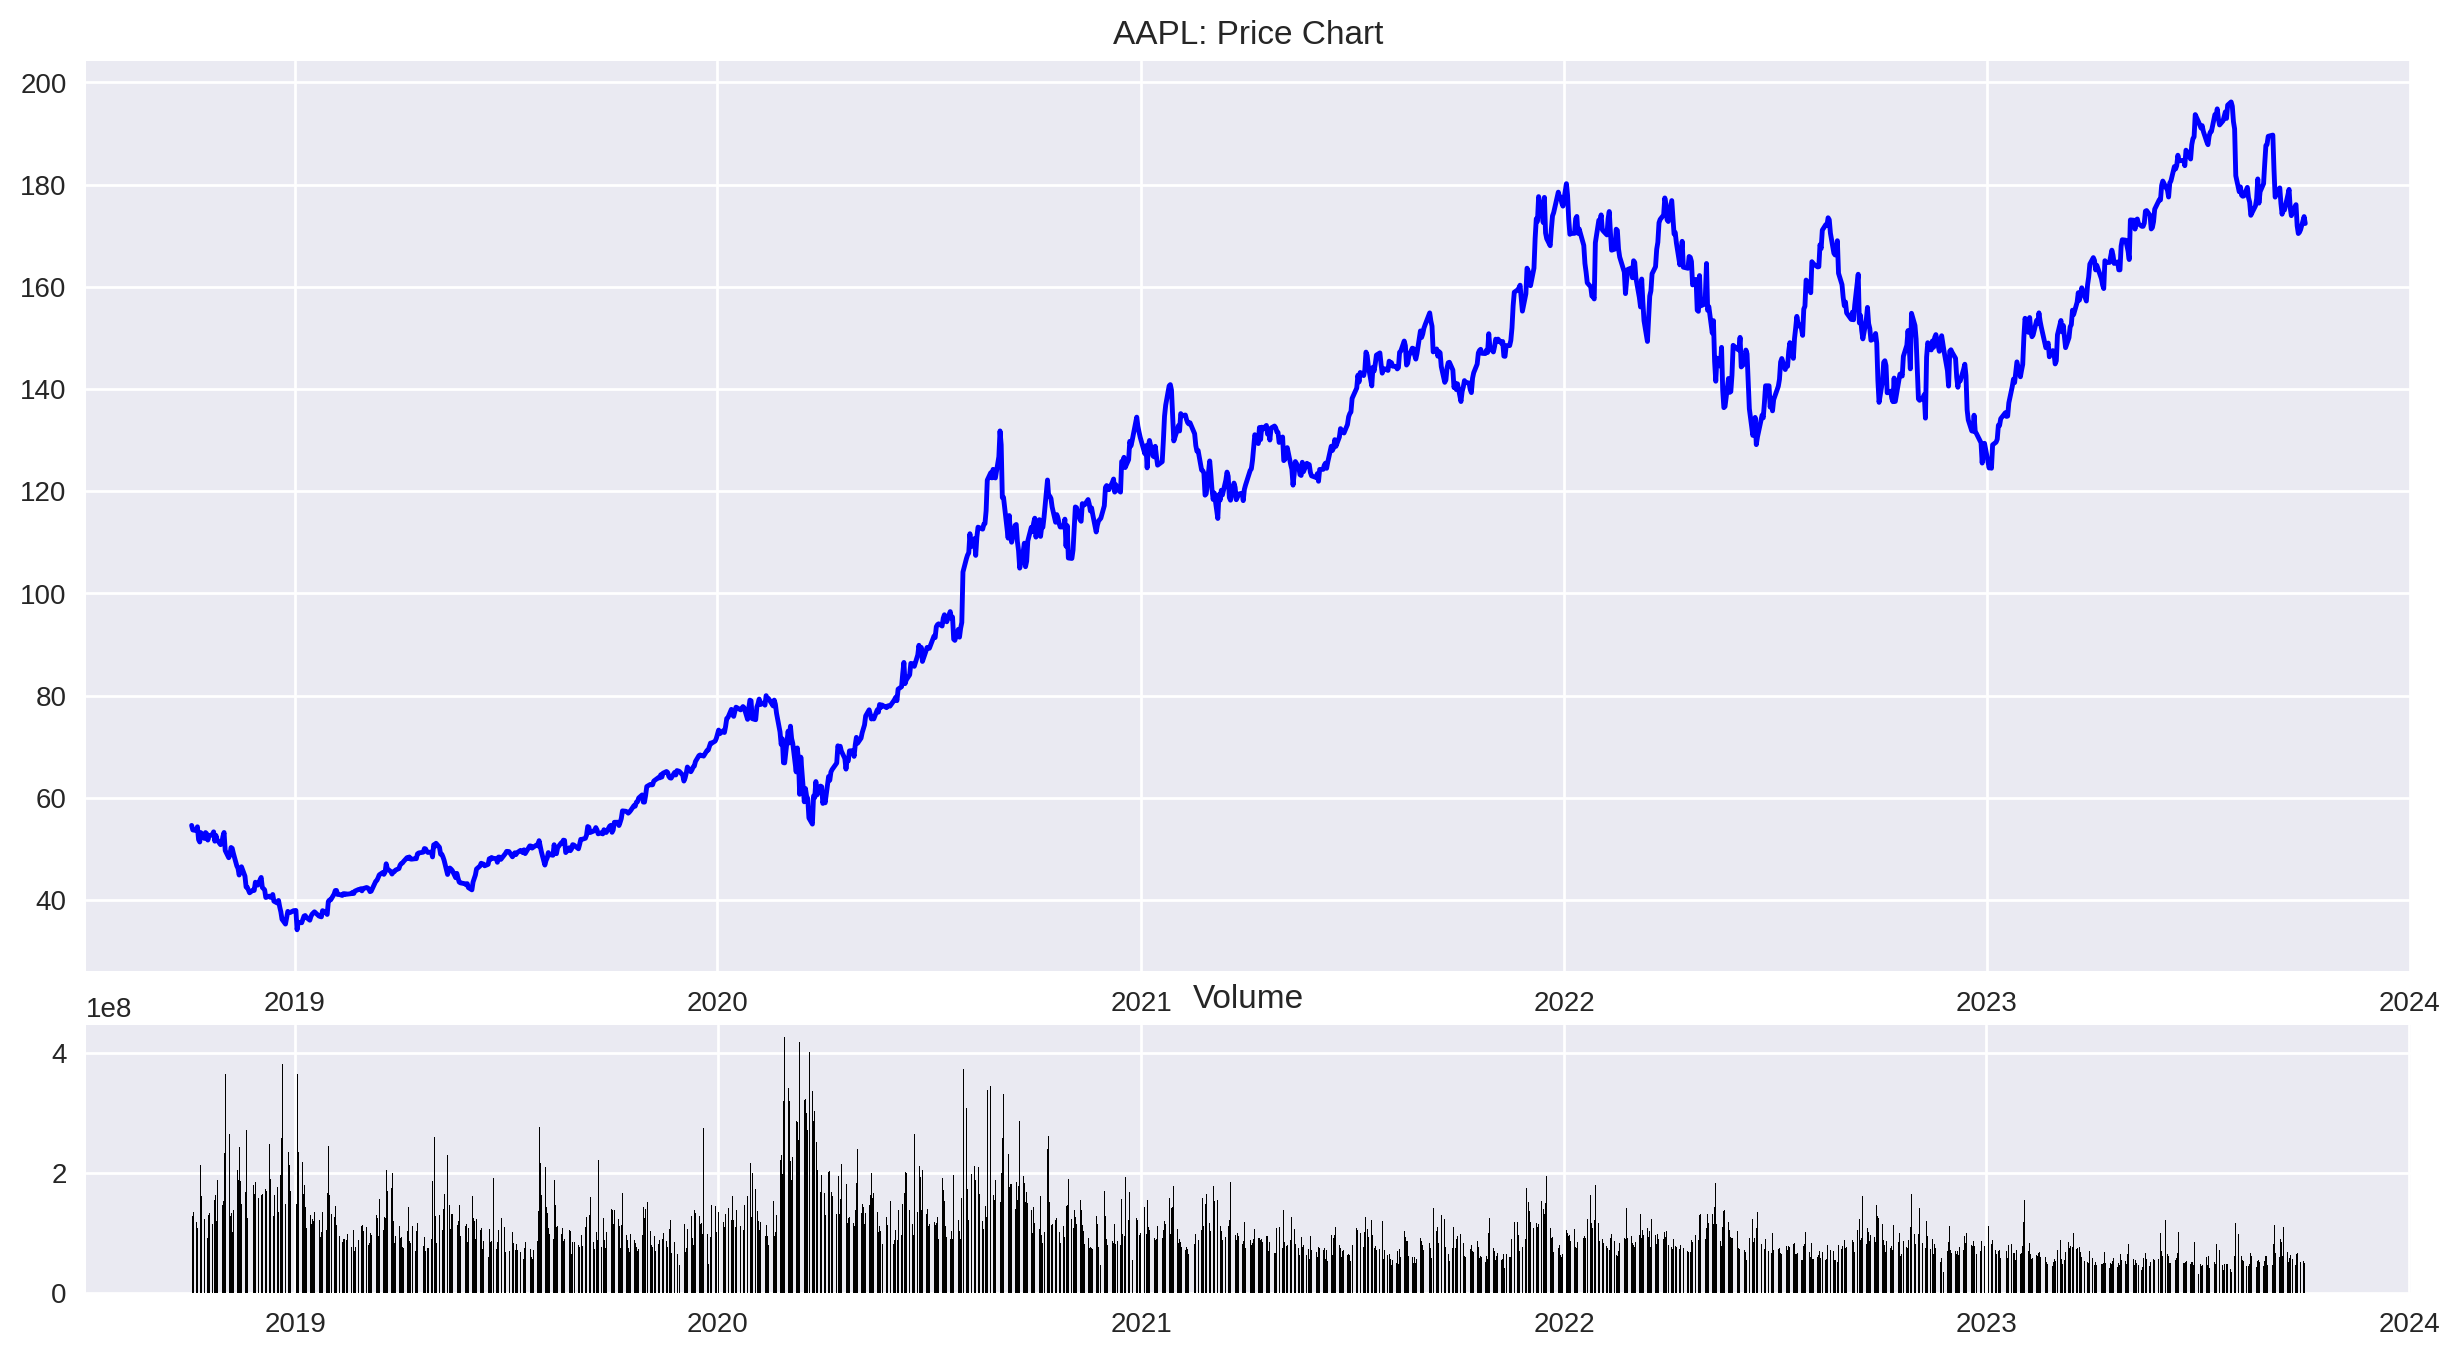

In [6]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(data_df.index, data_df["Close"], color='blue')
plt.title(f'{company}: Price Chart')

bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(data_df.index, data_df['Volume'], color='black')
plt.title('Volume')

plt.gcf().set_size_inches(15,8)

## Convertir precios en rendimientos

Existen dos formas de convertir precios en rendimientos:

1. Rendimientos aritméticos: $r_t = \frac{P_t}{P_{t-1}} - 1$

2. Rendimientos logarítmicos: $r_t = ln(\frac{P_t}{P_{t-1}})$ 

Ambos rendimientos son equivalentes cuando los rendimientos son pequeños. Veamos como se comportan los rendimientos aritméticos y logarítmicos para distintos valores de rendimiento:

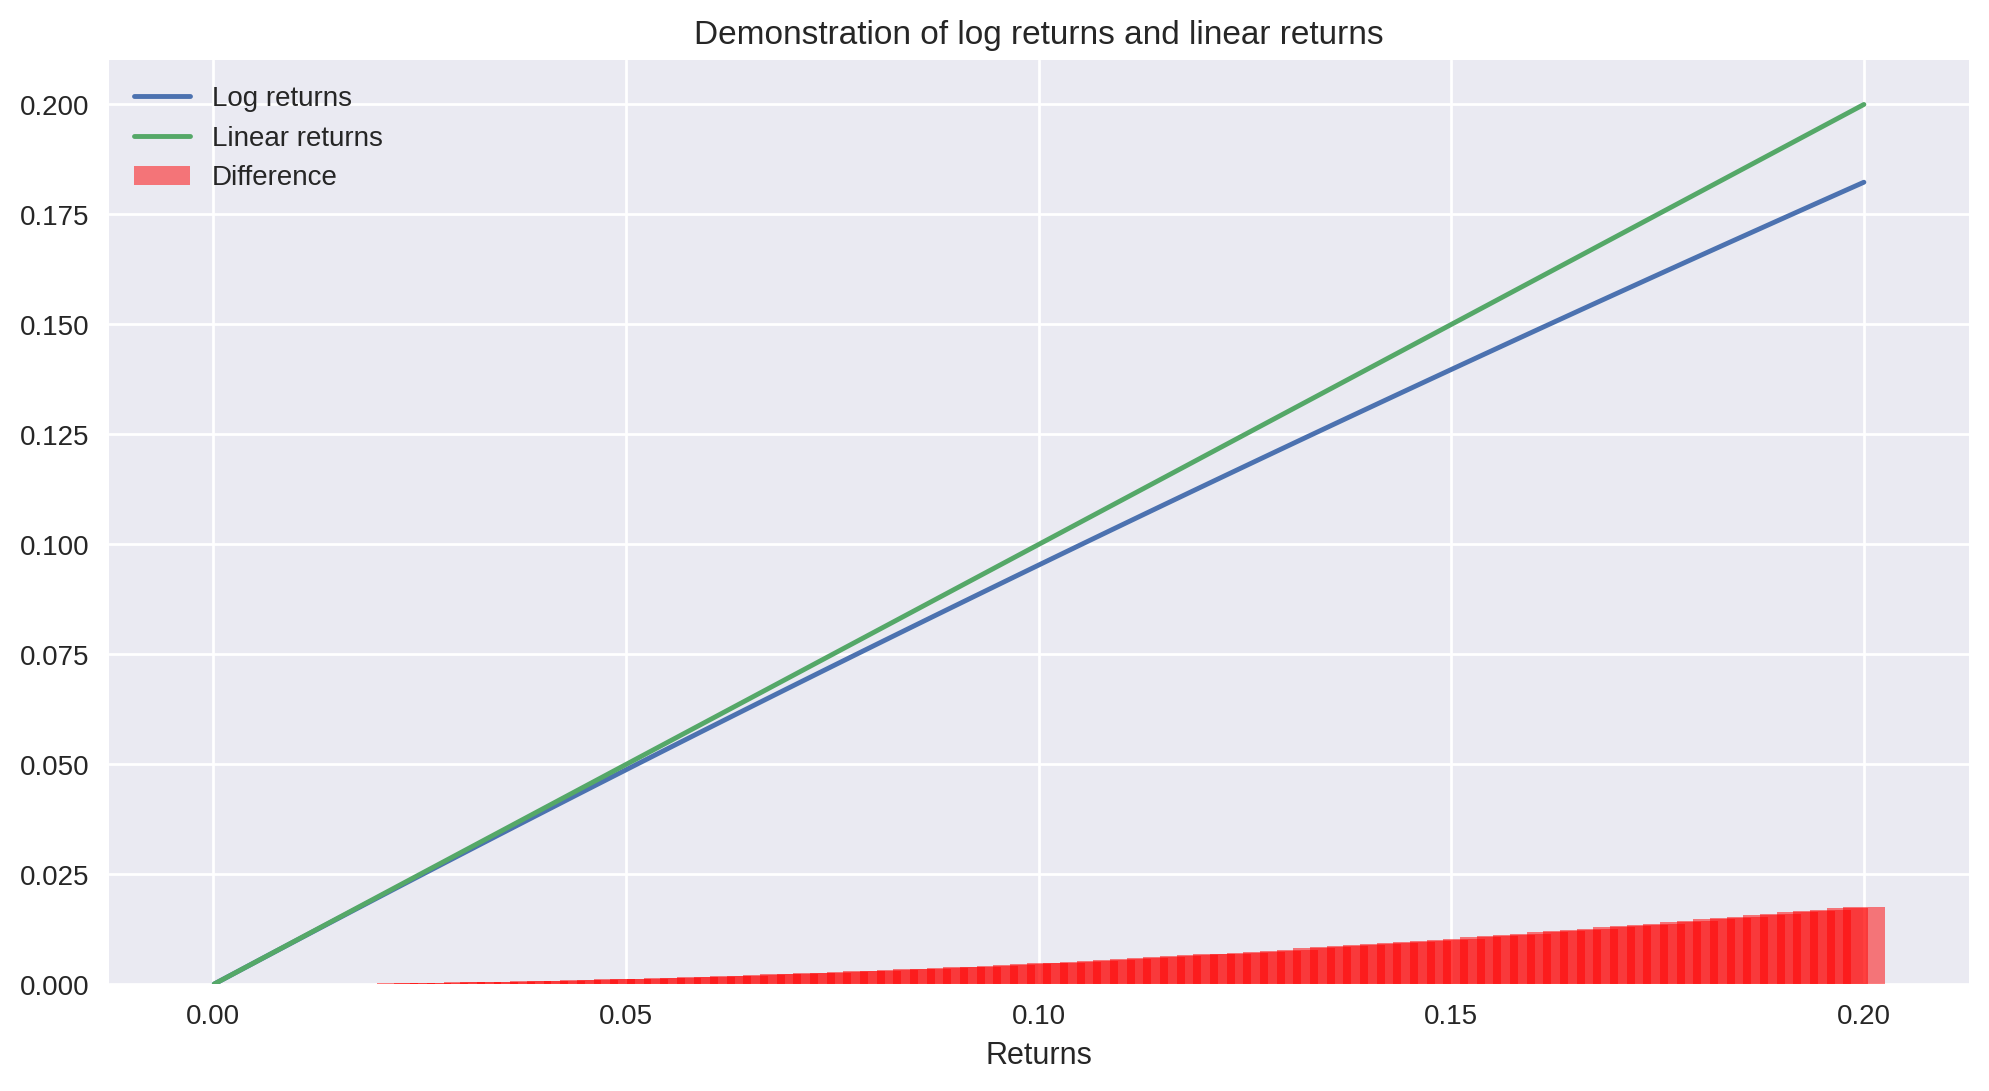

In [7]:
x_returns = np.linspace(0.0001, .2, 100) # Generate 100 numbers between 0.0001 and 0.2
y_returns = np.log(1 + x_returns) # Calculate the logarithmic returns from the linear returns

# Plot the linear and log returns
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(x_returns, y_returns, label='Log returns') # Plot the log returns
plt.plot(x_returns, x_returns, label='Linear returns') # Plot the linear returns
plt.bar(x_returns, x_returns-y_returns, width=0.005, color='r', alpha=0.5, label='Difference', ) # Plot the difference between the two returns
plt.legend()
plt.xlabel('Returns')
plt.title('Demonstration of log returns and linear returns');

Seleccionamos los precios de cierre

In [19]:
precios_df = data_df.loc[:, 'Close']
precios_df = pd.DataFrame(precios_df)
precios_df.head(2)

,Close
Date,
2018-10-04 00:00:00-04:00,54.588425
2018-10-05 00:00:00-04:00,53.702522


Calculamos los retornos logarítmicos

In [21]:
ret_df = np.log(precios_df).diff().dropna()
ret_df.head(2)

,Close
Date,
2018-10-05 00:00:00-04:00,-0.016362
2018-10-08 00:00:00-04:00,-0.002321


<Axes: xlabel='Date'>

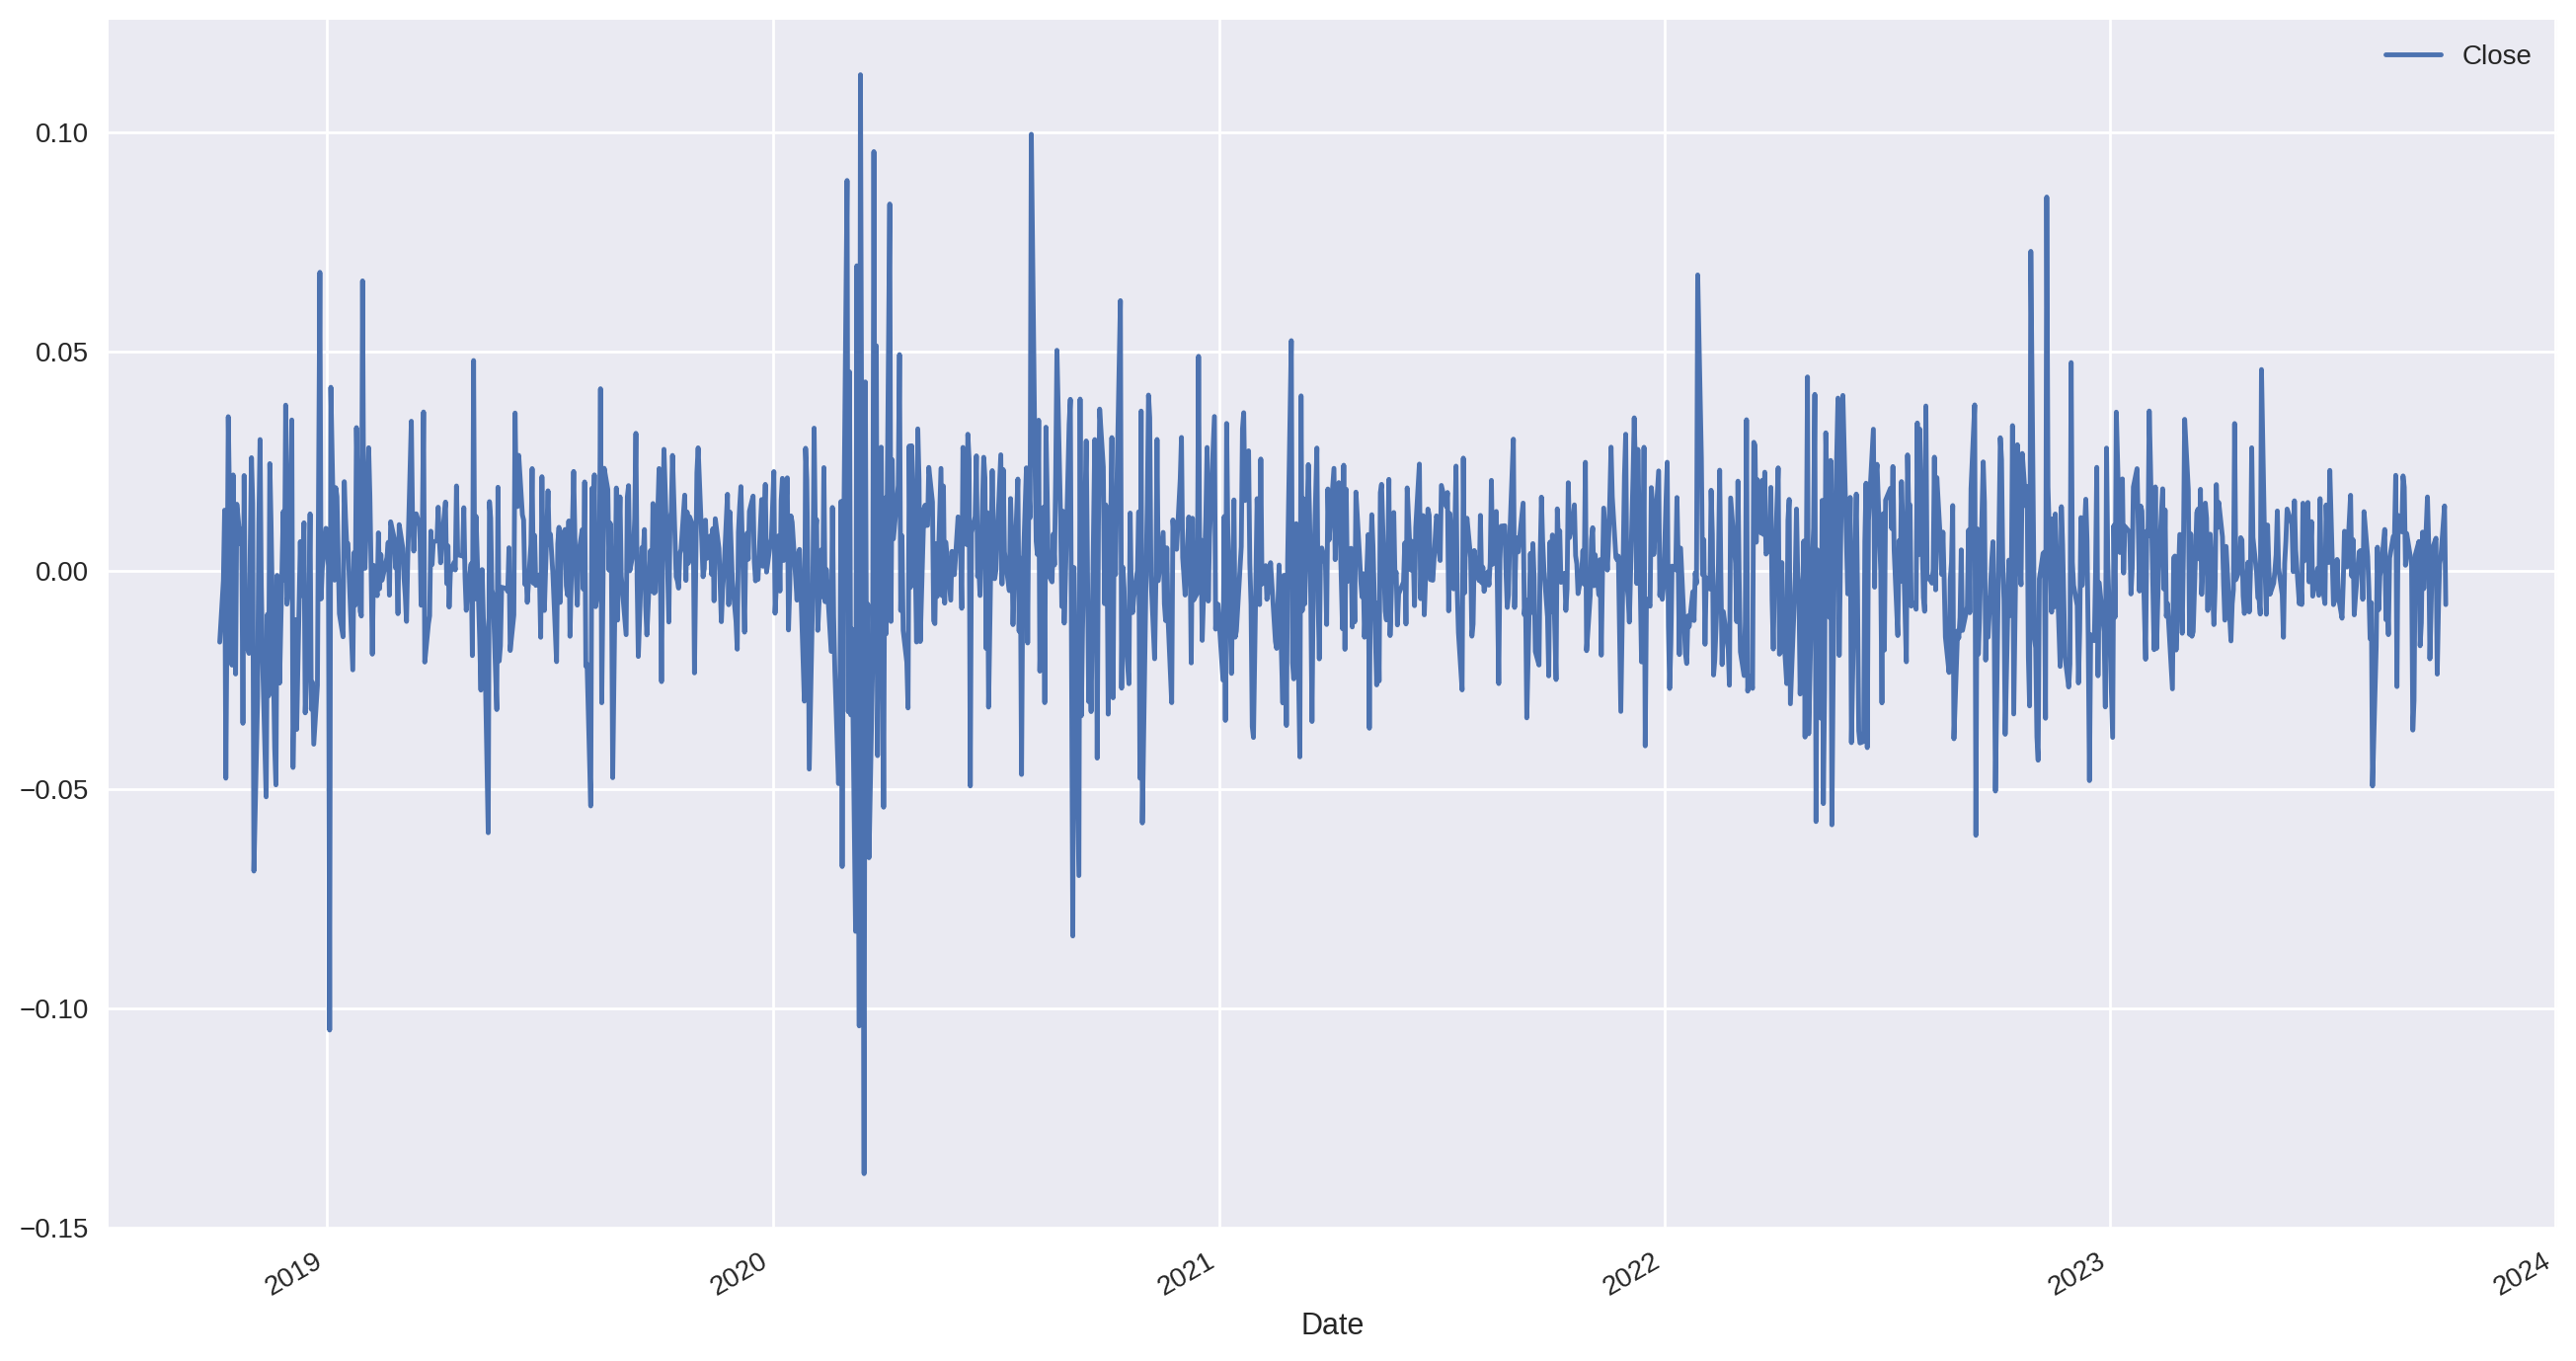

In [22]:
ret_df.plot()